# Creating segmentation masks using K-Means clustering.

This notebook contains algorithms to create segmentation masks by using K-Means clustering. The pixel getting clustered with KMeans in terms of their value and a gaussian filter is applied, afterwards. Pixels are classified as non-cell type below a defined threshold and classified as cell type when their values exceed this threshold.

In [9]:
import pandas as pd
import numpy as np
import pathlib
import os
import cv2

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from skimage.io import imread


In [2]:
# Get the directory of the repository
curr_dir = os.getcwd()
parent_dir = pathlib.Path(curr_dir).parents[1]
print(parent_dir)

/Users/philipp/neuefische/WHAT-THE-CELL...-AND-WHERE-


In [3]:
def save_seg_img(img_list, path_list):
    
    "Function saves clustered images"
    
    home_path = str(parent_dir) + '/data/data_preprocessed/mask_cluster/before_preprocessing/segmented_img/'
    
    save_seg_dic = {k: v for k, v in zip(path_list, img_list)}
    for path, img in save_seg_dic.items():
        id_img = path.split('/')[-1].split('.')[0]
        cv2.imwrite(home_path + id_img + '_seg.png', img*255.)

In [4]:
# Load the train.csv to write a new file that contains the sliced image file names
df = pd.read_csv(str(parent_dir) + '/data/data_original/train.csv')
df = df[['id','cell_type']]
df = df.drop_duplicates(subset=['id'])

In [5]:
# choose only astro images
path_list_astro = df.query('cell_type == "astro"')

# put paths of astro cell images in a list
astros = []
for img in range(0,len(path_list_astro.id.to_list())):
    astros.append(str(parent_dir) + '/data/data_original/train/' + str(path_list_astro.id.to_list()[img]) + '.png')

In [6]:
astro_img = []

#iterate trough astros list
for i, path in enumerate(astros):
    if i % 10 == 0:
        print(i, 'images processed')
        
    # load original image and reshape it so that kmeans works    
    img = imread(path)
    img_reshaped = img.reshape(img.shape[0] * img.shape[1], 1)
    
    # run kmeans on img_reshaped and reshape it to get back original shape
    kmeans_orig = KMeans(n_clusters=80, n_init= 5, 
               max_iter=50, random_state= 42).fit(img_reshaped)
    img_kmeans = np.reshape(np.array(kmeans_orig.labels_, dtype=np.uint8),(img.shape[0], img.shape[1]))
    
    # run gauss filter over img_kmeans
    kerne_size = 12
    kernel = np.ones((kerne_size,kerne_size),np.float32)/(kerne_size**2)
    gauss = cv2.filter2D(img_kmeans,-1,kernel)
    
    # Set a threshold that assigns pixels to the mask or background (non cell area) in terms of brightness
    # threshold is the mean value of the brightness + 2
    threshold = gauss.mean() + 2
    pred_mask = gauss.copy()
    pred_mask[pred_mask <= threshold] = 0
    pred_mask[pred_mask > threshold] = 1
    
    # put created masks in astro_img list
    astro_img.append(pred_mask)
    

0 images processed
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed


In [7]:
# save masks
save_seg_img(astro_img, astros)

# Visualisation of process

* Image 1 = original image;
* Image 2 = after k-Means; 
* Image 3 = after gaussian filter; 
* Image 4 = created mask

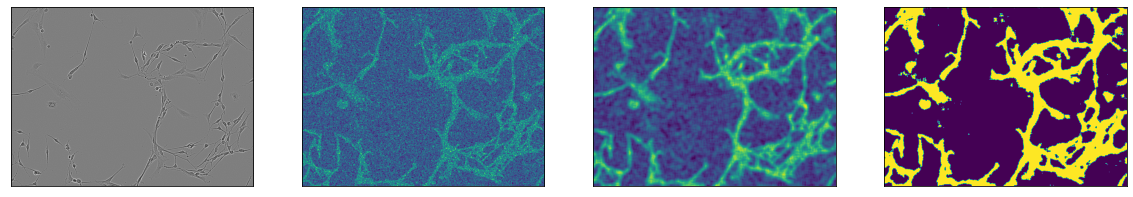

In [17]:
ig, arr = plt.subplots(1,4, figsize=(20, 20))
arr[0].imshow(img, cmap='gray')
arr[1].imshow(img_kmeans)
arr[2].imshow(gauss)
arr[3].imshow(pred_mask)
arr[0].set_xticks([])
arr[0].set_yticks([])
arr[1].set_xticks([])
arr[1].set_yticks([])
arr[2].set_xticks([])
arr[2].set_yticks([])
arr[3].set_xticks([])
arr[3].set_yticks([])
plt.savefig("kmeans_example_orig.png", dpi=300)

In [16]:
# Store the images for later post processing
cv2.imwrite("kmeans_ex_image.png", img)
cv2.imwrite("kmeans_ex_kmeans.png", img_kmeans)
cv2.imwrite("kmeans_ex_gauss.png", gauss)
cv2.imwrite("kmeans_ex_mask.png", pred_mask)

True